# Setting up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import shap
import seaborn as sns

from sklearn import datasets, tree
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

# Import data
from preprocessing import load_bikes_prepr

# Interpretability measures
from interpretability import PDP, generate_counterfactuals, inverse_transform
import lime
import lime.lime_tabular

In [ ]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('neg_root_mean_squared_error'), cv=KFold())
    clf.fit(X_train, y_train)

    return clf

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)

    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print("RMSE ({}): {}".format(model_name, rmse))
    r2 = r2_score(y_test, y_pred)
    print("R-squared score ({}) : {}".format(model_name, r2))

In [ ]:
X, y, feature_names, categorical = load_bikes_prepr()
seed = 3012

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
print(X.shape)

(17379, 12)


In [ ]:
d1 = {float(i): i for i in range(24)}
print(d1)

inv_dicts = {
    "season": {1.0: "Winter", 2.0: "Spring", 3.0: "Summer", 4.0: "Fall"},
    "yr": {0.0: 2011, 1.0: 2012},
    "mnth": {1.0: "JAN", 2.0: "FEB", 3.0: "MAR", 4.0: "APR", 5.0: "MAY", 6.0: "JUN", 7.0: "JUL", 8.0: "AUG", 9.0: "SEP", 10.0: "OCT", 11.0: "NOV", 12.0: "DEC"},
    "hr": d1,
    "holiday": {0.0: "No holiday", 1.0: "Holiday"},
    "weekday": {0.0: "MON", 1.0: "TUE", 2.0: "WED", 3.0: "THU", 4.0: "FRI", 5.0: "SAT", 6.0: "SUN"},
    "workingday": {0.0: "No working day", 1.0: "Working day"},
    "weathersit": {1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4}
}

{0.0: 0, 1.0: 1, 2.0: 2, 3.0: 3, 4.0: 4, 5.0: 5, 6.0: 6, 7.0: 7, 8.0: 8, 9.0: 9, 10.0: 10, 11.0: 11, 12.0: 12, 13.0: 13, 14.0: 14, 15.0: 15, 16.0: 16, 17.0: 17, 18.0: 18, 19.0: 19, 20.0: 20, 21.0: 21, 22.0: 22, 23.0: 23}


# Training models

## Sci-kit learn models

In [ ]:
model_names = [
    "k-nearest neighbors regressor", 
    "decision tree regressor",
    "linear regression",
    ]

parameters = {
    "k-nearest neighbors regressor": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')},
    "decision tree regressor": {'criterion': ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')}, #, 'splitter': ('best', 'random') , 'min_samples_split': np.arange(2, 20)},
    "linear regression": {}
    }

models_init = {
    "k-nearest neighbors regressor": KNeighborsRegressor(),
    "decision tree regressor": tree.DecisionTreeRegressor(random_state=seed),
    "linear regression": LinearRegression()
    }

models = dict()
train_times = dict()

for model_name in model_names:
    start = time.time()
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train, y_train)
    models[model_name] = clf.best_estimator_
    end = time.time()
    train_times[model_name] = (end - start)

    print(f"Training {model_name} done!")

Training k-nearest neighbors regressor done!
Training decision tree regressor done!
Training linear regression done!


## Neural network

In [ ]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train_nn.shape[1]

set_seed(seed)

start = time.time()
model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
# model.add(Dense(10, activation="relu"))
# model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam',
                loss="mean_absolute_error",
                metrics=['mean_squared_error'])

n_epochs = 1763
# n_epochs = 600
history = model.fit(X_train_nn, y_train_nn, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val_nn, y_val_nn))
end = time.time()
models["neural network"] = model
train_times["neural network"] = (end - start)

174/174 [==============================] - 0s 2ms/step - loss: 61.0082 - mean_squared_error: 11385.5419 - val_loss: 45.7563 - val_mean_squared_error: 5912.5312
Epoch 1265/1763
174/174 [==============================] - 0s 2ms/step - loss: 60.8231 - mean_squared_error: 10652.6964 - val_loss: 45.5878 - val_mean_squared_error: 5776.8003
Epoch 1266/1763
174/174 [==============================] - 0s 2ms/step - loss: 63.2718 - mean_squared_error: 12419.3850 - val_loss: 45.6923 - val_mean_squared_error: 5761.9209
Epoch 1267/1763
174/174 [==============================] - 0s 2ms/step - loss: 62.7116 - mean_squared_error: 12071.2464 - val_loss: 45.0376 - val_mean_squared_error: 5763.4268
Epoch 1268/1763
174/174 [==============================] - 0s 2ms/step - loss: 61.7901 - mean_squared_error: 11692.7004 - val_loss: 45.2864 - val_mean_squared_error: 5741.9219
Epoch 1269/1763
174/174 [==============================] - 0s 2ms/step - loss: 61.5933 - mean_squared_error: 11205.8984 - val_loss: 46.1

## Errors and times

In [ ]:
for name, model_time in train_times.items():
    print(f"Model {name} took {model_time} seconds to train")

Model k-nearest neighbors regressor took 75.61017656326294 seconds to train
Model decision tree regressor took 32.651771783828735 seconds to train
Model linear regression took 0.05719614028930664 seconds to train
Model neural network took 586.436408996582 seconds to train


In [ ]:
for model_name, model in models.items():
    print_errors(model, model_name, X_test, y_test)

RMSE (k-nearest neighbors regressor): 103.10120115294886
R-squared score (k-nearest neighbors regressor) : 0.6724614088049821
RMSE (decision tree regressor): 59.08524918675938
R-squared score (decision tree regressor) : 0.8924295043405996
RMSE (linear regression): 140.7242912588483
R-squared score (linear regression) : 0.3897986460392312
RMSE (neural network): 74.80886915527783
R-squared score (neural network) : 0.827558732490639


In [ ]:
inference_times = dict()

X_copy = np.tile(X_test[:50], (20000, 1))

for model_name, model in models.items():
    start = time.time()
    y_pred = model.predict(X_copy)
    end = time.time()
    inference_times[model_name] = (end - start)

for model_name, inference_time in inference_times.items():
    print(f"Model {model_name} took {inference_time} seconds to make 1 000 000 predictions")

Model k-nearest neighbors regressor took 103.2516553401947 seconds to make 10 000 000 predictions
Model decision tree regressor took 0.11798763275146484 seconds to make 10 000 000 predictions
Model linear regression took 0.01459050178527832 seconds to make 10 000 000 predictions
Model neural network took 30.9861102104187 seconds to make 10 000 000 predictions


# Intrinsic interpretability

In [ ]:
dtr_feat_imps = models["decision tree regressor"].feature_importances_

linreg_coefs = models["linear regression"].coef_
linreg_feat_imps = np.abs(linreg_coefs) / np.sum(np.abs(linreg_coefs))

intr_feat_imps = pd.DataFrame({"decision tree regressor": dtr_feat_imps, "linear regression": linreg_feat_imps}, index=feature_names)
intr_feat_imps.plot.bar()

# plt.show()
plt.tight_layout()
plt.savefig(f"Figures/bikes/intrinsic_feature_importance_bikes.png", dpi=300)
plt.close()

# Partial dependence plots

In [ ]:
def inverse_transform(X, feat_idx, scaler):
    return X * np.sqrt(scaler.var_[feat_idx]) + scaler.mean_[feat_idx]

k-nearest neighbors regressor


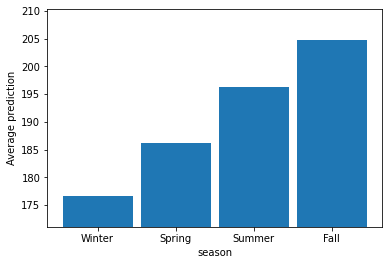

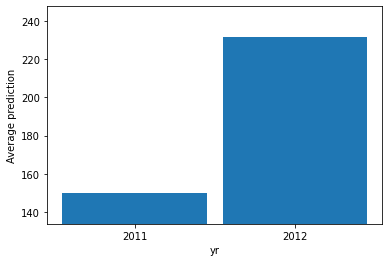

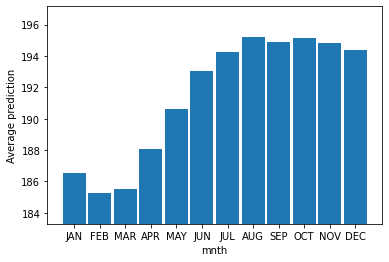

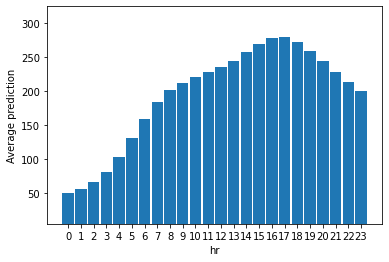

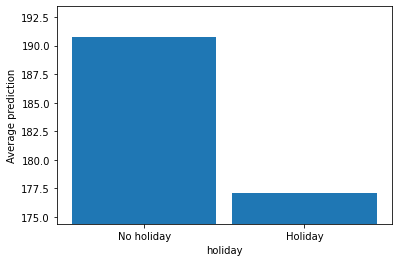

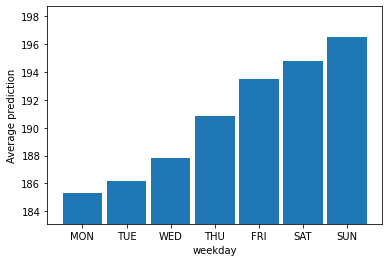

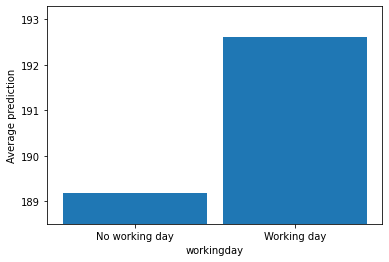

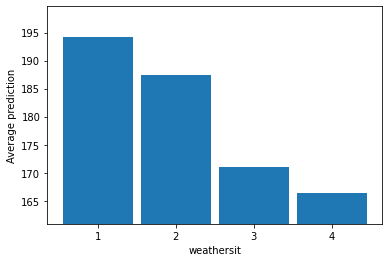

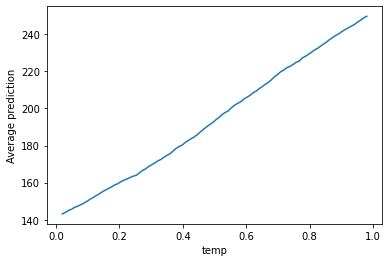

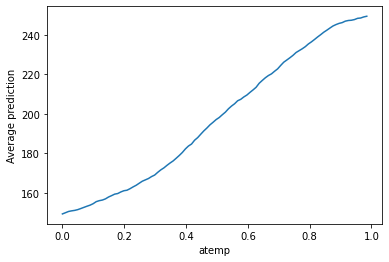

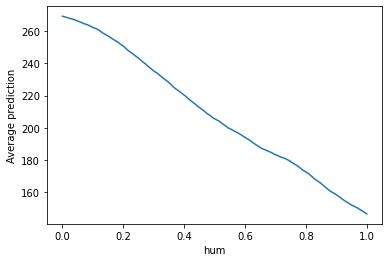

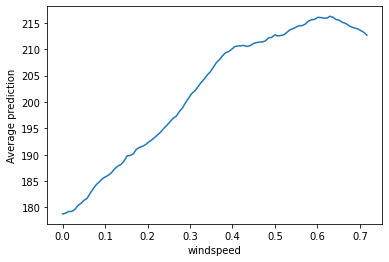

decision tree regressor


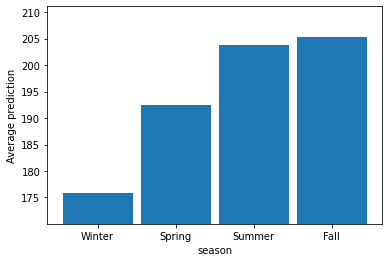

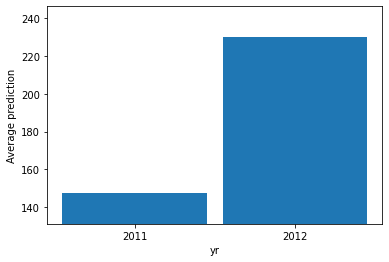

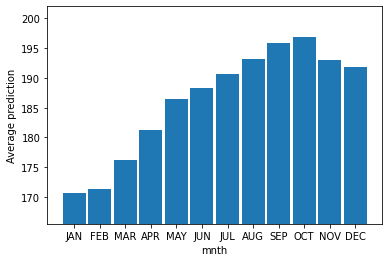

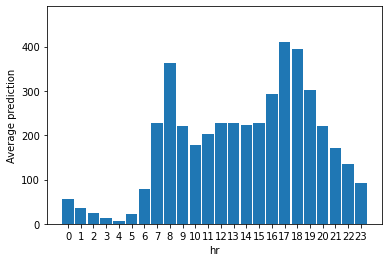

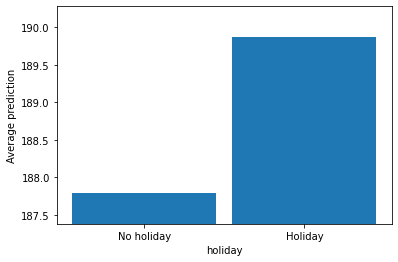

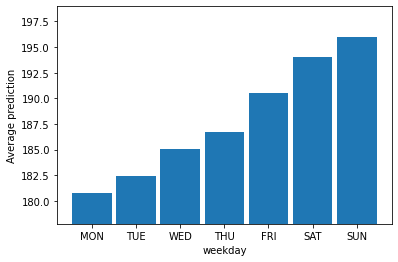

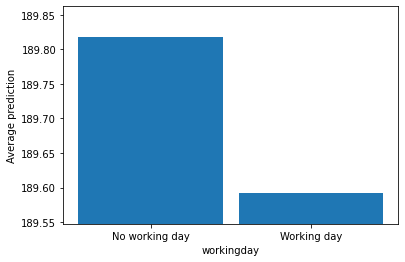

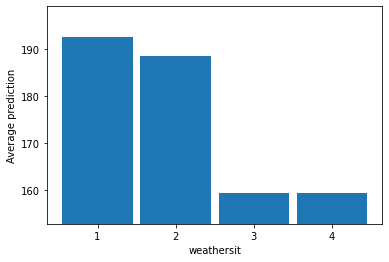

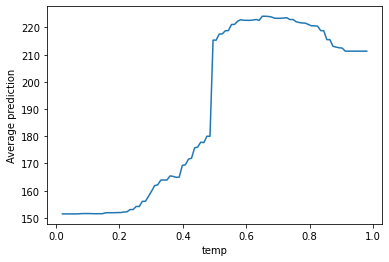

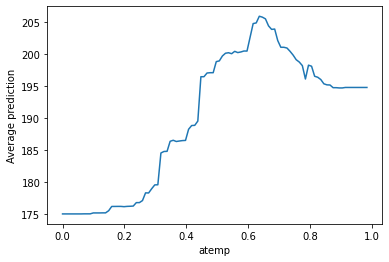

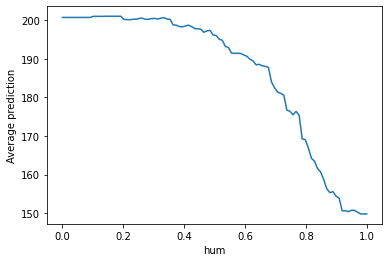

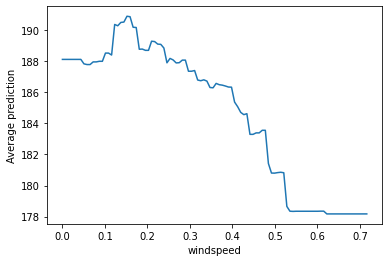

linear regression


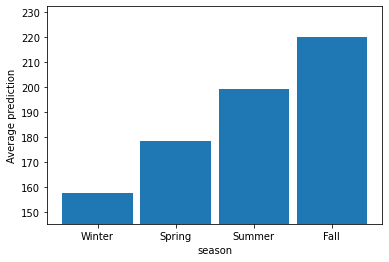

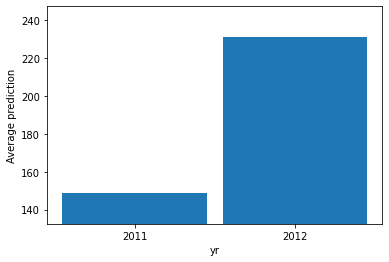

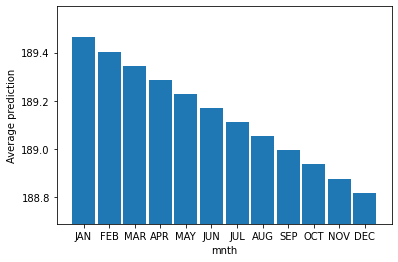

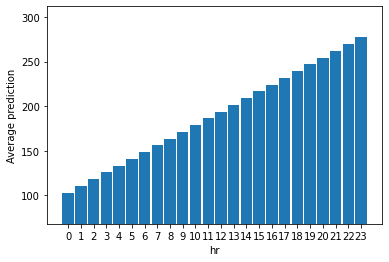

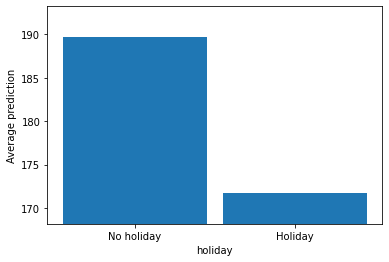

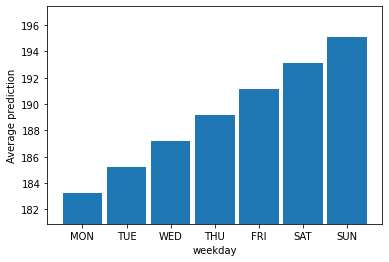

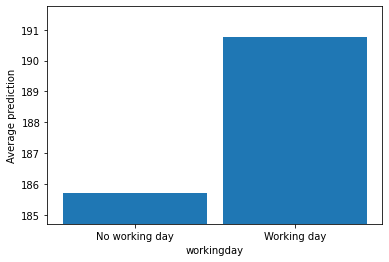

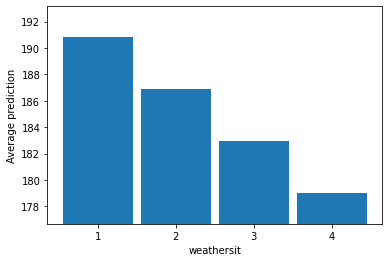

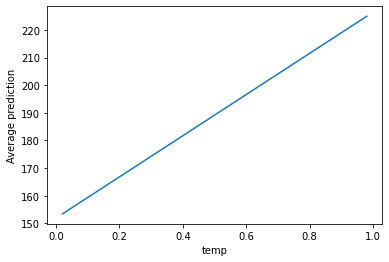

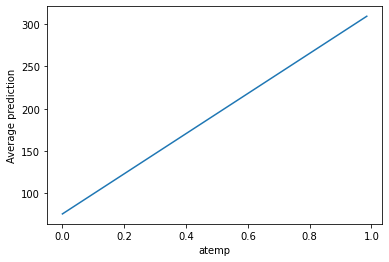

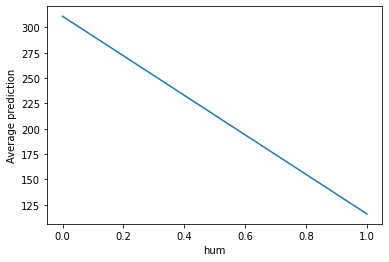

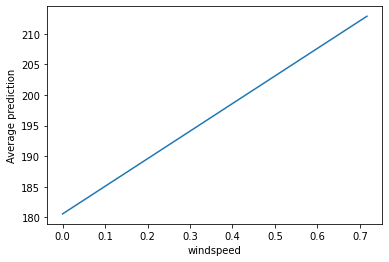

neural network


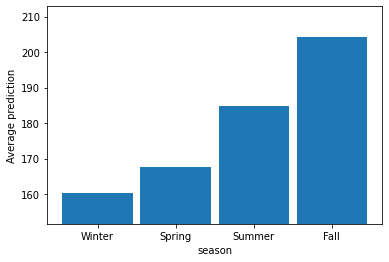

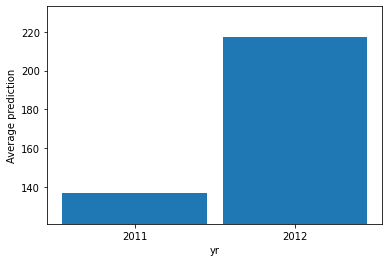

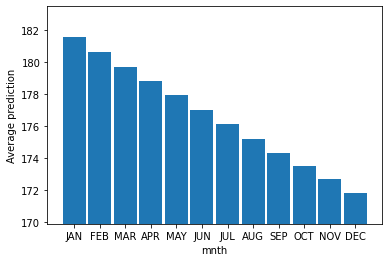

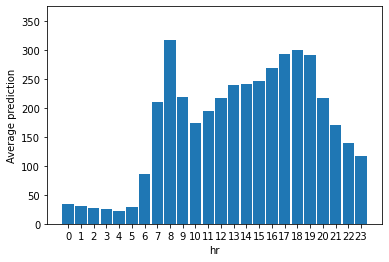

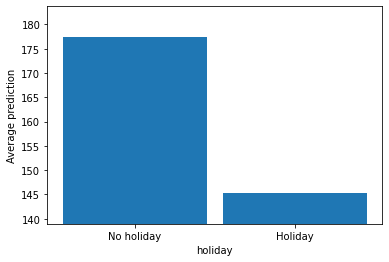

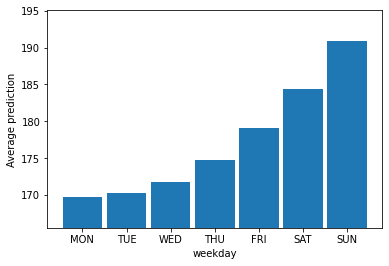

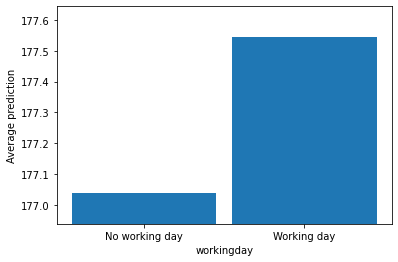

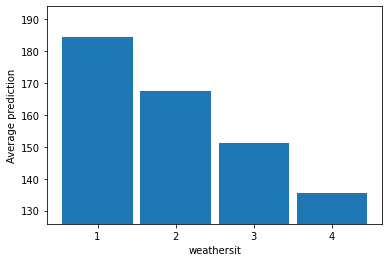

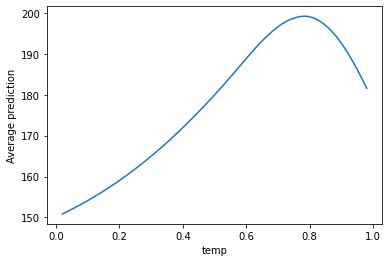

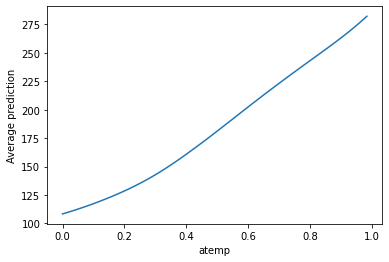

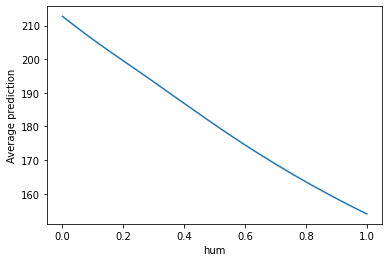

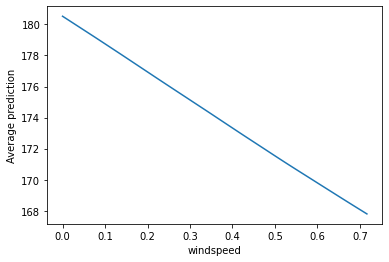

In [ ]:
for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(len(feature_names)):
        feat_values, PDP_values = PDP("regression", i, feature_names[i], model, X_test, y_test, categorical=categorical[i])

        # Make a line plot if feature is not categorical and a bar plot if it is categorical
        plt.xlabel(feature_names[i])
        plt.ylabel("Average prediction")

        original_feat_values = inverse_transform(feat_values, i, scaler)

        if not categorical[i]:
            plt.plot(original_feat_values, PDP_values)
        else:
            diff = max(PDP_values) - min(PDP_values)
            if diff != 0.0:
                plt.ylim(max(min(PDP_values) - 0.2 * diff, 0.0), max(PDP_values) + 0.2 * diff)
            else:
                plt.ylim(min(PDP_values) - 0.001, max(PDP_values) + 0.001)
            
            tick_label = original_feat_values

            if feature_names[i] in inv_dicts.keys():
                tick_label = list()
                for value in original_feat_values:
                    tick_label.append(inv_dicts[feature_names[i]][round(value, 2)])

            plt.bar(original_feat_values, PDP_values, width=(original_feat_values[1]-original_feat_values[0]) * 0.9, tick_label=tick_label)

        plt.show()
        plt.savefig(f"Figures/bikes/PDP_bikes_{model_name}_{i}.png", dpi=300)
        plt.close()

# SHAP

## Instance-based interpretation

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, y_pred.shape[0])
      return y_pred

    explainers[model_name] = shap.KernelExplainer(nn_predict, shap.kmeans(X_train, 250)) # shap.kmeans(X_train, 200))
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 250))

Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 250 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
idx = 54
shap_instance_times = dict()

for model_name in models.keys():
    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    start = time.time()
    explainer = explainers[model_name]
    shap_instance = explainer.shap_values(X_test_df.iloc[idx])
    end = time.time()

    shap_instance_times[model_name] = (end - start)

    # PLOT SHAP VALUES IN NORMAL WAY
    shap_instance = pd.DataFrame(shap_instance, index=feature_names)
    shap_instance.plot.bar(legend=None)
    plt.tight_layout()
    plt.savefig(f"Figures/bikes/SHAP_instance_bikes_{model_name}_{idx}.png", dpi=300)
    plt.close()

    # shap.initjs()
    # shap.force_plot(explainer.expected_value, shap_instance, X_test_df.iloc[idx])

In [ ]:
for model_name, model_time in shap_instance_times.items():
    print(f"Model {model_name} took {model_time} seconds to explain an instance using SHAP")

Model k-nearest neighbors regressor took 99.08462166786194 seconds to explain an instance using SHAP
Model decision tree regressor took 4.54822850227356 seconds to explain an instance using SHAP
Model linear regression took 3.642946243286133 seconds to explain an instance using SHAP
Model neural network took 13.14814305305481 seconds to explain an instance using SHAP


In [ ]:
print(X_copy.shape)

(1000000, 12)


## Global interpretation

    shap_global_times = dict()
    # X_test_df = pd.DataFrame(X_test, columns=feature_names)

    for model_name in models.keys():
        start = time.time()
        print(model_name)
        explainer = explainers[model_name]

        shap_values = explainer.shap_values(shap.sample(X_test, 50, random_state=seed))
        np.savetxt(f"Output/bikes/shap_values_bikes_{model_name}.txt", shap_values)
        end = time.time()

        shap_global_times[model_name] = (end - start)

    for name, model_time in shap_global_times.items():
        print(f"Model {name} took {model_time} seconds to explain using SHAP")

In [ ]:
shap_values_all = dict()

for model_name in models.keys():
    shap_values_all[model_name] = np.loadtxt(f"Output/bikes/shap_values_bikes_{model_name}.txt")

In [ ]:
shap_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shap_feat_imps.insert(0, model_name, feat_imps)

In [ ]:
shap_feat_imps.plot.bar()
plt.ylabel("SHAP feature importance")
plt.tight_layout()
plt.savefig("Figures/bikes/SHAP_feature_importance_bikes.png", dpi=300)
plt.close()

# Counterfactuals

In [ ]:
instance_idx = 0
counterfactual_times = dict()

total_time = 500 # !!!

for model_name in models.keys():
    instance = X_test[instance_idx]
    model = models[model_name]

    start = time.time()
    counterfactuals, counterfactual_losses = generate_counterfactuals("regression", instance, X_train, model, categorical, seed, goal_pred=200.0, tol=1.0, total_time=500)
    end = time.time()

    counterfactual_times[model_name] = (end - start)

    np.savetxt(f"Output/bikes/counterfactuals_bikes_{model_name}_instance{instance_idx}.txt", counterfactuals)
    np.savetxt(f"Output/bikes/counterfactual_losses_bikes_{model_name}_instance{instance_idx}.txt", counterfactual_losses)

Original prediction: 111.45144034865746
100%|██████████| 500/500 [00:39<00:00, 12.62it/s]
Counterfactual_losses: [3.37908951 3.62262259 3.87404297 3.9838184  5.25279944 5.52257288
 5.55558986 5.85753475 7.11231213 7.19323985]
Original prediction: 101.0
100%|██████████| 500/500 [00:10<00:00, 48.03it/s]
Counterfactual_losses: [ 9.14372876  9.59693098  9.67367692 10.01846367 11.34506716 11.56205693
 12.85953282 13.53773442 13.56573799 14.26610126]
Original prediction: 88.85810083116719
100%|██████████| 500/500 [00:07<00:00, 67.84it/s]
Counterfactual_losses: [2.92749496 3.18741452 4.36171581 4.48833709 6.23065135 6.76101246
 6.88065306 7.0187925  7.43368711 7.6924182 ]
Original prediction: 92.34130859375
100%|██████████| 500/500 [36:58<00:00,  4.44s/it]Counterfactual_losses: [3.32351455 4.1980449  4.31417548 5.28107871 5.8292139  6.01334406
 6.08067599 6.41807744 7.25579788 7.6593653 ]



In [ ]:
for model_name, model_time in counterfactual_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate counterfactuals")

Model k-nearest neighbors regressor took 39.61764407157898 seconds to generate counterfactuals
Model decision tree regressor took 10.418658018112183 seconds to generate counterfactuals
Model linear regression took 7.3798511028289795 seconds to generate counterfactuals
Model neural network took 2218.419013738632 seconds to generate counterfactuals


# LIME

## Instance-based interpretability

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, 
    feature_names=['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'], 
    class_names=['Cnt'], 
    categorical_features=[0, 1, 2, 3, 4, 5, 6, 7], 
    verbose=True, mode='regression')

In [ ]:
np.random.seed(seed)
idx = 50
lime_times = dict()

for name in models.keys():
    print(f"Lime explanation for {name}")
    start = time.time()

    exp = explainer.explain_instance(X_test[idx], models[name].predict, num_features=12) # Change num_featurese for more or less explainations
    exp.show_in_notebook(show_table=True)

    end = time.time()
    lime_times[name] = (end - start)

print(f"Actual value is: {y_test[idx]}")

Lime explanation for k-nearest neighbors regressor
Intercept 169.60381713500195
Prediction_local [326.61277127]
Right: 184.17520098729617


Lime explanation for decision tree regressor
Intercept 237.13805469198508
Prediction_local [252.52973439]
Right: 221.0


Lime explanation for linear regression
Intercept 167.53459850858007
Prediction_local [302.34026106]
Right: 256.71693492393774


Lime explanation for neural network
Intercept 144.1794107972048
Prediction_local [290.90105929]
Right: 189.79012


Actual value is: 218.0


In [ ]:
for model_name, model_time in lime_times.items():
    print(f"Model {model_name} took {model_time} seconds to generate an explanation using LIME")

Model k-nearest neighbors regressor took 7.455625534057617 seconds to generate an explanation using LIME
Model decision tree regressor took 4.924813508987427 seconds to generate an explanation using LIME
Model linear regression took 5.0193705558776855 seconds to generate an explanation using LIME
Model neural network took 5.927055358886719 seconds to generate an explanation using LIME


## Global interpretation

In [ ]:
lime_global_times = dict()
np.random.seed(seed)

for model_name in models.keys():
    start = time.time()
    print(model_name)
    lime_values = np.zeros((50, len(feature_names)))

    for idx, instance in enumerate(shap.sample(X_test, 50, random_state=seed)):
        exp = explainer.explain_instance(instance, models[model_name].predict, num_features=12)
        exp_dict = exp.as_map()

        for feat_idx, lime_value in exp_dict[1]:
            lime_values[idx, feat_idx] = lime_value

    end = time.time()
    lime_global_times[model_name] = (end - start)
    np.savetxt(f"Output/bikes/lime_values_bikes_{model_name}.txt", lime_values)
    print("---------------------------------------------------------------")

k-nearest neighbors regressor
Intercept 146.038738421767
Prediction_local [94.81537331]
Right: 44.88494106277687
Intercept 96.52900664731317
Prediction_local [284.00580361]
Right: 279.80758333043707
Intercept 226.68841422875732
Prediction_local [154.53163521]
Right: 146.76355168325347
Intercept 121.07491765241694
Prediction_local [228.15772526]
Right: 147.49300637236578
Intercept 165.61872049968662
Prediction_local [359.10108917]
Right: 230.99883909954445
Intercept 229.59391962850708
Prediction_local [16.36659807]
Right: 76.94164541697063
Intercept 135.71554298136218
Prediction_local [274.23668862]
Right: 151.04248517231073
Intercept 185.1972923777283
Prediction_local [221.69466571]
Right: 179.7109365932165
Intercept 190.19468695491403
Prediction_local [291.86091604]
Right: 316.3078935576895
Intercept 249.47265153884905
Prediction_local [41.90179034]
Right: 35.613755153312525
Intercept 230.8174451080587
Prediction_local [30.12730826]
Right: 29.838826815765348
Intercept 215.432155988219

In [ ]:
for name, model_time in lime_global_times.items():
    print(f"Model {name} took {model_time} seconds to explain using LIME")

Model k-nearest neighbors regressor took 373.0125048160553 seconds to explain using LIME
Model decision tree regressor took 253.98873329162598 seconds to explain using LIME
Model linear regression took 170.27070593833923 seconds to explain using LIME
Model neural network took 173.11849689483643 seconds to explain using LIME


In [ ]:
lime_values_all = dict()

for model_name in models.keys():
    lime_values_all[model_name] = np.loadtxt(f"Output/bikes/lime_values_bikes_{model_name}.txt")

In [ ]:
lime_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  lime_values = lime_values_all[model_name]
  feat_imps = np.mean(np.abs(lime_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  lime_feat_imps.insert(0, model_name, feat_imps)

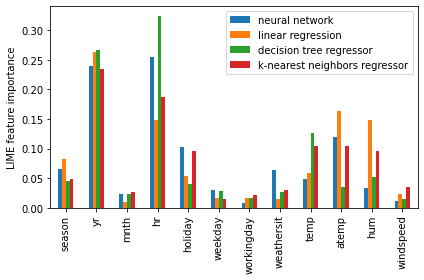

In [ ]:
lime_feat_imps.plot.bar()
plt.ylabel("LIME feature importance")
plt.tight_layout()
plt.savefig("Figures/bikes/LIME_feature_importance_bikes.png", dpi=300)
plt.show()
plt.close()

# Comparing feature importances

    intr_mapper = dict()
    shap_mapper = dict()

    for model_name in models.keys():
        intr_mapper[model_name] = model_name + " (intrinsic)"
        shap_mapper[model_name] = model_name + " (SHAP)"

    all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper)], axis=1)

In [ ]:
intr_mapper = {
    "decision tree regressor": "dtr (intr)", 
    "linear regression": "lr (intr)", 
    "k-nearest neighbors regressor": "knn (intr)", 
    "neural network": "nn (intr)",
    }

shap_mapper = {
    "decision tree regressor": "dtr (SHAP)", 
    "linear regression": "lr (SHAP)", 
    "k-nearest neighbors regressor": "knn (SHAP)", 
    "neural network": "nn (SHAP)",
    }

lime_mapper = {
    "decision tree regressor": "dtr (LIME)", 
    "linear regression": "lr (LIME)", 
    "k-nearest neighbors regressor": "knn (LIME)", 
    "neural network": "nn (LIME)",
    }

all_feat_imps = pd.concat([intr_feat_imps.rename(columns=intr_mapper, errors="ignore"), shap_feat_imps.rename(columns=shap_mapper), lime_feat_imps.rename(columns=lime_mapper)], axis=1)

In [ ]:
all_feat_imps_columns = all_feat_imps.columns
jaccard_sim = pd.DataFrame(np.zeros((len(all_feat_imps_columns), len(all_feat_imps_columns))), index=all_feat_imps_columns, columns=all_feat_imps_columns)
jaccard_sims = list()

for k in range(1, len(feature_names) + 1):
    for column_name_1 in all_feat_imps_columns:
        for column_name_2 in all_feat_imps_columns:
            feat_imps_1 = np.array(all_feat_imps[column_name_1])
            feat_imps_2 = np.array(all_feat_imps[column_name_2])

            top_features_1 = feature_names[np.argsort(feat_imps_1)][::-1][:k]
            top_features_2 = feature_names[np.argsort(feat_imps_2)][::-1][:k]

            union = len(top_features_1)
            intersec = 0

            for feature in top_features_1:
                if feature in top_features_2:
                    intersec += 1
                else: 
                    union += 1

            jaccard_sim[column_name_1][column_name_2] = intersec / union

    f, ax = plt.subplots(figsize=(6, 6), dpi=300)
    sns.heatmap(jaccard_sim, vmin=0.0, vmax=1.0, annot=True, square=True)
    plt.tight_layout()
    plt.savefig(f"Figures/bikes/jaccard_bikes_top_{k}.png")
    plt.close()

    jaccard_sims.append(jaccard_sim.copy())

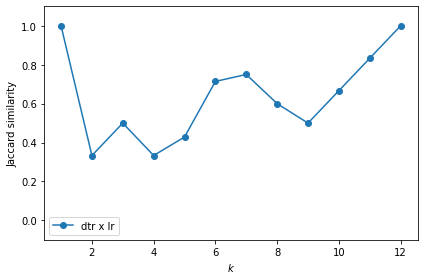

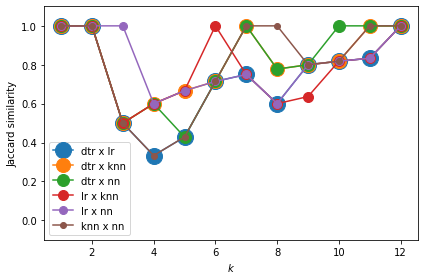

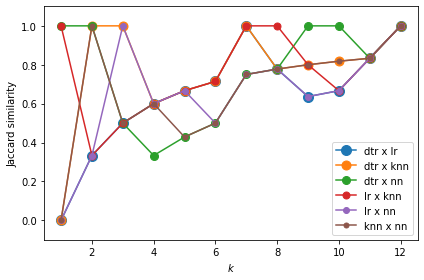

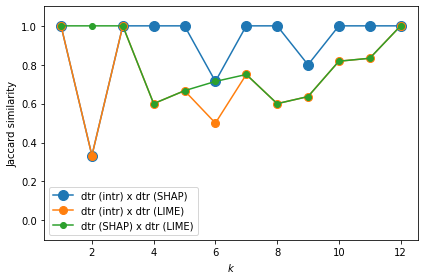

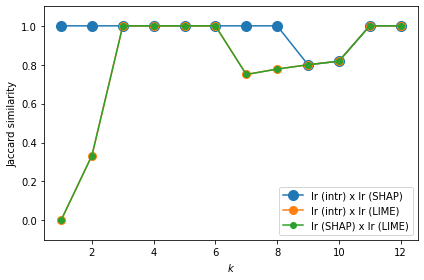

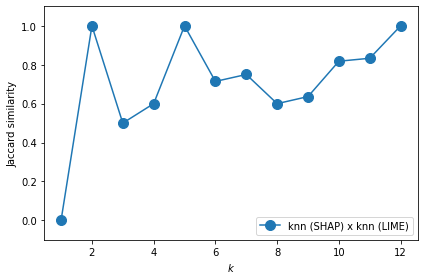

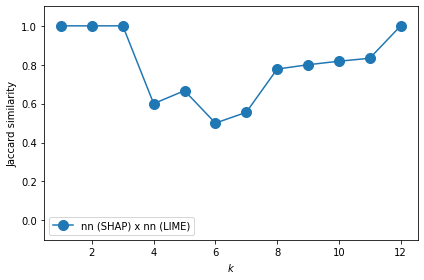

In [ ]:
# Compare intrinsic values
compairs = [("dtr (intr)", "lr (intr)")]

for pair in compairs:
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o")

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_intr_models.png", dpi=300)
plt.show()
plt.close()

# Compare SHAP values
compairs = [
    ("dtr (SHAP)", "lr (SHAP)"),
    ("dtr (SHAP)", "knn (SHAP)"),
    ("dtr (SHAP)", "nn (SHAP)"),
    ("lr (SHAP)", "knn (SHAP)"),
    ("lr (SHAP)", "nn (SHAP)"),
    ("knn (SHAP)", "nn (SHAP)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=16-2.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_SHAP_models.png", dpi=300)
plt.show()
plt.close()

# Compare LIME models
compairs = [
    ("dtr (LIME)", "lr (LIME)"),
    ("dtr (LIME)", "knn (LIME)"),
    ("dtr (LIME)", "nn (LIME)"),
    ("lr (LIME)", "knn (LIME)"),
    ("lr (LIME)", "nn (LIME)"),
    ("knn (LIME)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1[:-7]} x {column_name_2[:-7]}", marker="o", markersize=10-1.0*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_LIME_models.png", dpi=300)
plt.show()
plt.close()

# Compare decision tree interpretability
compairs = [
    ("dtr (intr)", "dtr (SHAP)"),
    ("dtr (intr)", "dtr (LIME)"),
    ("dtr (SHAP)", "dtr (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_decision_tree_regressor.png", dpi=300)
plt.show()
plt.close()

# Compare linear regression interpretability
compairs = [
    ("lr (intr)", "lr (SHAP)"),
    ("lr (intr)", "lr (LIME)"),
    ("lr (SHAP)", "lr (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_linear_regression.png", dpi=300)
plt.show()
plt.close()

# Compare kNN interpretability
compairs = [
    ("knn (SHAP)", "knn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_k_nearest_neighbors_regressor.png", dpi=300)
plt.show()
plt.close()

# Compare neural network interpretability
compairs = [
    ("nn (SHAP)", "nn (LIME)"),
    ]

for i, pair in enumerate(compairs):
    column_name_1, column_name_2 = pair
    sim_values = list()
    for k in range(len(feature_names)):
        jaccard_sim = jaccard_sims[k]
        sim_values.append(jaccard_sim[column_name_1][column_name_2])
    plt.plot(np.arange(1, len(feature_names) + 1), sim_values, label=f"{column_name_1} x {column_name_2}", marker="o", markersize=10-2*i)

plt.xlabel(r"$k$")
plt.ylabel("Jaccard similarity")
plt.ylim(-0.1, 1.1)
plt.tight_layout()
plt.legend()
plt.savefig(f"Figures/bikes/jaccard_neural_network_regressor.png", dpi=300)
plt.show()
plt.close()

# Prutsen

In [ ]:
from anchor import anchor_tabular

In [ ]:

cat_dict = {1: ["0: test", "1:Winter", "2:Spring", "3:Summer", "4:Fall"],
 2: ["2011", "2012"], 3: [" ","Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
  4: [i for i in range(1,25)], 5: ["No", "Yes"],
   6: ["", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    7: ["Not working", "Working"], 8: ["Unknown", " Clear, Few clouds", "Mist", "Light snow or rain", "Heavy rain or thunderstorm"]}
class_names = "Cnt"
anch_exp = anchor_tabular.AnchorTabularExplainer(
    class_names,
    ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed'],
    X_train,
    cat_dict
)

idx = 76

tmp = X_test[idx].reshape(1, -1)
np.random.seed(20)
t =  anch_exp.class_names[int(
    models["k-nearest neighbors regressor"].predict(tmp))]
print(t)

expl = anch_exp.explain_instance(
    X_test[idx],
     models["k-nearest neighbors regressor"].predict, threshold=0.6) # Change threshold a bit for more interesting anchors :P 0.6 gives a good one!

print('Anchor: %s' % (' AND '.join(expl.names())))
print('Precision: %.2f' % expl.precision())
print('Coverage: %.2f' % expl.coverage())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>